In [30]:
import numpy as np
import pandas as pd
from datetime import datetime
from collections import Counter
import time
import os.path
import json
import bokeh
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import Category20_20, Category10_10, Dark2_8, Set2_8, Accent8
from bokeh.models import ColumnDataSource, DatetimeTickFormatter, HoverTool, Range1d
from itertools import cycle
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
sns.set()

In [36]:
bokeh.__version__

'1.3.0'

In [31]:
COLORS = Category20_20[::2] + Category20_20[1::2] + Accent8 + Category20_20[1::2]

In [32]:
class FacebookChat:
    # Only for non group messages
    DELETED_USER = "Deleted User"
    def __init__(self, json):
        self.json = json
        self.participants = [x["name"] for x in json["participants"]]
        self.total_messages = len(json["messages"])
        self.messages_sent = 0 # how this is handled is actually shit but im too lazy
        self.total_words = 0
        self.words_sent = 0
        self.total_stickers = 0
        self.stickers_sent = 0
        self.words = {p: {} for p in self.participants}
        
        if "title" not in json:
            self.title = json["thread_path"]
        elif len(self.participants) == 2:
            self.title = self.participants[0]
        else:
            self.title = json["title"]
            
        categories = ["messages", "words", "stickers"]
        self.data = {cat : data for cat, data in zip(categories, self.detailed_breakdown_by_date())}
        
        
    def breakdown_by_date(self, mode):
        '''msgs_by_date is a dict {date : num <mode>}'''
        if mode == "messages":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["messages"].items()}
        elif mode == "words":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["words"].items()}
        elif mode == "stickers":
            return {date: sum(ind_breakdown.values())
                for date, ind_breakdown in self.data["stickers"].items()}
    
    def detailed_breakdown_by_date(self):
        '''detailed_breakdown is a nested dictionary {dates : {person : num_messages}}'''
        detailed_breakdown_messages, detailed_breakdown_words, detailed_breakdown_stickers = {}, {}, {}
        words_per_message = {p: (0, 0) for p in self.participants}
        for msg in self.json["messages"]:
            
            date = ms_to_date(msg["timestamp_ms"])
            person = msg["sender_name"] if "sender_name" in msg else FacebookChat.DELETED_USER
            msg_content = msg["content"].split(' ') if 'content' in msg else [] # usually a sticker if no content
            msg_length = len(msg_content)
            self.total_words += msg_length
            
            if person in self.participants:
                for word in msg_content:
                    word = word.lower()
                    person_words = self.words[person]
                    person_words[word] = person_words.get(word, 0) + 1
                    self.words[person] = person_words
                
            
            if "sticker" in msg:
                self.total_stickers += 1
                stk_breakdown = detailed_breakdown_stickers.get(date, {})
                ind_stk = stk_breakdown.get(person, 0)
                stk_breakdown[person] = ind_stk + 1
                detailed_breakdown_stickers[date] = stk_breakdown
                
                if "sender_name" in msg and msg["sender_name"] == NAME:
                    self.stickers_sent += 1
            
            msg_breakdown = detailed_breakdown_messages.get(date, {})
            word_breakdown = detailed_breakdown_words.get(date, {})
            
            # inner dictionary
            ind_msg = msg_breakdown.get(person, 0)
            msg_breakdown[person] = ind_msg + 1
            detailed_breakdown_messages[date] = msg_breakdown
            
            ind_word = word_breakdown.get(person, 0)
            word_breakdown[person] = ind_word + msg_length
            detailed_breakdown_words[date] = word_breakdown
            
            if "sender_name" in msg and msg["sender_name"] == NAME:
                self.messages_sent += 1
                self.words_sent += msg_length
            
    
        return (detailed_breakdown_messages, detailed_breakdown_words, detailed_breakdown_stickers)
    
    def group_breakdown_by_date(self):
        pass
    
    def is_groupchat(self):
        return len(self.participants) > 2
    
    def is_deleted_user(self):
        return not self.is_groupchat() and '' in self.participants
    
    def get_data(self, mode, start_date=None, end_date=None): # Change this so it isnt none
        if mode == "messages":
            return self.data["messages"]
        elif mode == "words":
            return self.data["words"]
        elif mode == "stickers":
            return self.data["stickers"]

def ms_to_date(ms):
    dt = datetime.fromtimestamp(ms//1000)
    return dt.strftime("%Y-%m")
    return "{}/{}".format(dt.month, dt.year) # puts it in M/YYYY format

def gen_total_df(chats, mode):
    all_data = {}
    other_counter = Counter()
    delete_counter = Counter()
    total = 0
    total_sent = 0
    for name, chat in chats.items():
        if chat.is_groupchat() and IGNORE_GROUPCHATS:
            continue
            
        if mode == "messages":
            total += chat.total_messages
            total_sent += chat.messages_sent
        elif mode == "words":
            total += chat.total_words
            total_sent += chat.words_sent
        elif mode == "stickers":
            total += chat.total_stickers
            total_sent += chat.stickers_sent
            
        if chat.is_deleted_user():
            delete_counter += Counter(chat.breakdown_by_date(mode))
        elif chat.total_messages < THRESHOLD:
            other_counter += Counter(chat.breakdown_by_date(mode))
        else:
            all_data[name] = chat.breakdown_by_date(mode)
            
    all_data["Deleted Users"] = dict(delete_counter)
    all_data["others"] = dict(other_counter)
    return all_data, total, total_sent

def make_autopct(values):
    def my_autopct(pct):
        total = sum(values)
        val = int(round(pct*total/100.0))
        return '{p:.2f}%  ({v:d})'.format(p=pct,v=val)
    return my_autopct

def sum_dict(d):
    return sum([x for x in d.values()])

def conv_to_perc(df):
    return df.divide(df.sum(axis=1), axis="rows")

def stacked(df): # straight from the docs, makes outlines of the glyphs
    df_top = df.cumsum(axis=1)
    df_bottom = df_top.shift(axis=1).fillna(0)
    df_line = (df_top + df_bottom)/2
    df_stack = pd.concat([df_bottom[::-1], df_top], ignore_index=True)
    return df_stack, df_line

def get_groupchats(chats):
    return {k : v for k, v in chats.items() if len(v.participants) > 2}

In [118]:
def area_plot(df, title):
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    N = len(df)

#     areas, lines = stacked(df)
#     x2 = np.hstack((df.index[::-1], df.index))
#     source_area = ColumnDataSource(dict(
#                 xs=[x2] * areas.shape[1],
#                 ys=[areas[c].values for c in areas],
#                 color=[COLOR_DICT[name] for name in list(df)],
#                 label=list(df),
#                 ))
#     print(source_area)
    
#     source_lines = ColumnDataSource(dict(
#                 xs=[lines.index] * lines.shape[1],
#                 ys=[lines[c].values for c in lines],
#                 color=colors,
#                 label=list(df)))
    

    tooltips = [("Person", "$name")]
    p = figure(x_axis_type="datetime", plot_width=PLOT_WIDTH, tooltips=tooltips, plot_height=PLOT_HEIGHT)
    p.xaxis[0].formatter = DatetimeTickFormatter(months="%b-%Y")
    p.grid.minor_grid_line_color = '#eeeeee'
    colors = [COLOR_DICT[name] for name in list(df)]

    p.varea_stack(stackers=list(df), x='index', color=colors, hover_color="black", name=list(df), source=df)
#     p.patches( xs='xs', ys='ys', color='color', name='area', source=source_area)
#     p.multi_line( xs='xs', ys='ys', color='#000000', name='lines', source=source_lines)
#     hover = HoverTool(
#         tooltips = [
#             ("Person", "$name"),
#             ("x", "$x"),
#         ],
#         point_policy="follow_mouse")
#     p.add_tools(hover)
    output_file('graphs/{}.html'.format(title), title=title)

    show(p)

In [81]:
df_msg.head()

,Aiswarya Sankar,Andrew Savage,Audrey Cui,Billy Zhao,Branden Lee,Catherine Xu,Daniel A. Wang,Deleted Users,Forest Yang,Henk Tillman,...,Tatiana Su,Thomas Chow,Timothy Lee,Varsha Venkat,William Zhao,Yani Mai,Yanis Ait Kaci Azzou,Yuna Shin,Zermina Wadood,others
2009-09,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2009-10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2010-03,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,8
2010-05,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,3
2010-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [111]:
from bokeh.palettes import brewer
from bokeh.core.properties import value
output_file('stacked_area.html')

N = 10
df = pd.DataFrame(np.random.randint(10, 100, size=(15, N))).add_prefix('y')
TOOLTIPS = [("xd", "$x")]
p = figure(x_range=(0, len(df)-1), y_range=(0, 800), tooltips=TOOLTIPS)
p.grid.minor_grid_line_color = '#eeeeee'

names = ["y%d" % i for i in range(N)]
p.varea_stack(stackers=names, x='index', color=brewer['Spectral'][N], legend=[value(x) for x in names], source=df)
p.circle([0], [0], size=20)
# reverse the legend entries to match the stacked order
p.legend[0].items.reverse()

show(p)

# Fill This Out

In [34]:
NAME = "Andrew Xu" # Name here
THRESHOLD = 1000 # threshold of messages before someone is considered others
IGNORE_GROUPCHATS = True  # whether to include groupchat in the analysis 

# Size of interactive plots
PLOT_WIDTH = 1600
PLOT_HEIGHT = 900

### Read in Data

In [35]:
files = os.listdir("messages/inbox")
ignore = [".DS_Store", "stickers_used"]
chats = {}

for file in files:
    if file in ignore:
        continue
    with open("messages/inbox/{}/message_1.json".format(file), "r") as f:
        data_json = json.load(f)
    if not "participants" in data_json:# or '' in data_json["participants"]:
        continue

    chat = FacebookChat(data_json)
    chats[chat.title] = chat

#### Set colors

In [90]:
all_data, total_msgs, total_msgs_sent = gen_total_df(chats, "messages")
df_msg = pd.DataFrame(all_data)
df_msg = df_msg.fillna(0)
all_word_data, total_words, total_words_sent = gen_total_df(chats, "words")
df_word = pd.DataFrame(all_word_data)
df_word = df_word.fillna(0)
all_sticker_data, total_stickers, total_stickers_sent = gen_total_df(chats, "stickers")
df_sticker = pd.DataFrame(all_sticker_data)
df_sticker = df_sticker.fillna(0)

colors = [x for _, x in zip(range(len(list(df_msg))), cycle(COLORS))]
COLOR_DICT = {name: color for name, color in zip(df_msg.sum().sort_values().index[::-1], colors)}

## Go one at a time please for the next 4 (Interactive graphs)

In [119]:
area_plot(df_msg, "Messages")
area_plot(conv_to_perc(df_msg), "Messages_Percentage")
bokeh.io.reset_output()
time.sleep(10)

In [12]:
area_plot(df_word, "Words")
area_plot(conv_to_perc(df_word), "Words_Percentage")
bokeh.io.reset_output()
time.sleep(10)

In [ ]:
area_plot(df_sticker, "Stickers")
area_plot(conv_to_perc(df_sticker), "Stickers_Percentage")
bokeh.io.reset_output()
time.sleep(10)

In [15]:
num_rows = 5
df_no_others = df_word.drop(['others'], axis=1)
df = conv_to_perc(df_no_others).reindex(pd.to_datetime(df_no_others.index))
ranking = df.values.argsort(axis=1)[:,-num_rows:]
names = list(df)
shape = np.shape(ranking)
ranking_names = np.reshape(np.array([names[x] for x in ranking.flatten()]), shape)

ind_rankings = {name:[np.nan]*len(ranking_names) for name in set(ranking_names.flatten())}
for date, rank in enumerate(ranking_names):
    for idx, name in enumerate(rank):
        ind_rankings[name][date] = idx

output_file("line.html")
p = figure(x_axis_type="datetime", x_range=Range1d(df.index.min(), df.index.max()),
           y_range=Range1d(-.2, num_rows - .8, bounds="auto"), plot_width=1600, plot_height=250,
          toolbar_location="left")
p.xaxis[0].formatter = DatetimeTickFormatter(months="%b-%Y")

for name, y in ind_rankings.items():
    color = COLOR_DICT[name]
    source = ColumnDataSource(dict(x=df.index, y=y, prop=df[name], size=df[name]*7.5 + 7.5,
                                   person=[name]*len(y)))
    p.line('x', 'y', line_color=color, line_width=1.5, source=source)
    p.scatter('x', 'y', size='size', fill_color=color, line_color=color, name=name, source=source)
hover = HoverTool(
    tooltips = [
        ("Person", "@person"),
        ("Proportion", "@prop")
    ],
    point_policy="follow_mouse",
    names=list(df))
p.add_tools(hover)
show(p)
# For windows
bokeh.io.reset_output()

# Misc Stats

In [16]:
# See who you message the most
df_msg.sum().sort_values()

Deleted Users                     0
Shanelle Asuncion Versoza      1168
Aiswarya Sankar                1289
Sara Gyi                       1403
Branden Lee                    1422
Simin Liu                      1434
Samad Patel                    1555
Hulkerine Way                  1711
Henk Tillman                   1740
Stephen Sue-Young Chang        1778
Audrey Cui                     1829
Stephanie Rillon               1885
Andrew Savage                  2281
William Zhao                   2349
Sylvia Bi                      2460
Jingjing Zhang                 2689
Joshua Kang                    2834
Joan Hsu                       3050
Jacob Holesinger               3155
Tatiana Su                     3202
Isaac Chan                     3264
Joseph Mink Kwon               3465
Jerry Zhao                     3484
James Ding                     6239
Daniel A. Wang                 6455
Megan Lee                      7792
Thomas Chow                    7888
Varsha Venkat               

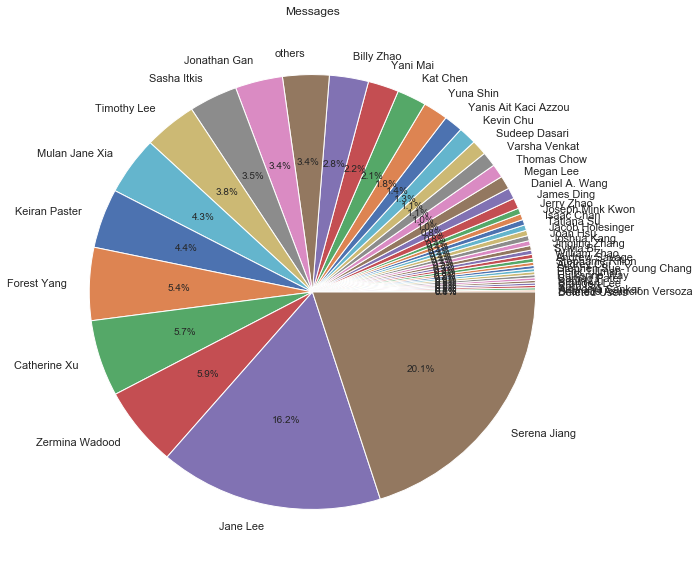

In [17]:
labels = list(df_msg.sum().sort_values().keys())
msgs = [x for x in list(df_msg.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Messages")
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_msg.sum().sort_values().keys(), y=df_msg.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Messages")
plt.show()


In [ ]:
print(df_word.sum().sort_values())

In [ ]:
labels = list(df_word.sum().sort_values().keys())
perc = [x for x in list(df_word.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Words")
plt.pie(perc, labels=labels, autopct='%.1f%%')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_word.sum().sort_values().keys(), y=df_word.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Words")
plt.show()


In [ ]:
# Average message length
(df_word.sum()/df_msg.sum()).sort_values()

In [ ]:
y_pos = np.arange(len(list(df_word)))
plt.figure(figsize=(10,10))
values = (df_word.sum()/df_msg.sum()).sort_values().values
labels = (df_word.sum()/df_msg.sum()).sort_values().keys()
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.title("Average WPM")
# plt.set_ytickslabels(labels)
plt.show()

In [ ]:
print(df_sticker.sum().sort_values())

In [ ]:
labels = list(df_sticker.sum().sort_values().keys())
perc = [x for x in list(df_sticker.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Stickers")
plt.pie(perc, labels=labels, autopct='%.1f%%')
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_sticker.sum().sort_values().keys(), y=df_sticker.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Stickers")
plt.show()

In [ ]:
(df_msg.sum()/df_sticker.sum()).sort_values()

In [ ]:

plt.figure(figsize=(10,10))
values = (df_msg.sum()/df_sticker.sum()).sort_values().values
labels = (df_msg.sum()/df_sticker.sum()).sort_values().keys()
new_values, new_labels = [], []
for value, label in zip(values, labels):
    if value < 1000:
        new_values.append(value)
        new_labels.append(label)
y_pos = np.arange(len(list(new_values)))
plt.barh(y_pos, new_values)
plt.yticks(y_pos, new_labels)
plt.title("Average Messages per Sticker")
# plt.set_ytickslabels(labels)
plt.show()

In [ ]:
print("total messages: {}".format(total_msgs))
print("total words: {}".format(total_words))
print("wpm: {}".format(total_words/total_msgs))


fig, axes = plt.subplots(1,3, figsize=(17,5))
labels = ["Messages Sent", "Messages Received", "Words Sent", "Words Received", "Stickers Sent", "Stickers Received"]
msg_vals = [total_msgs_sent, total_msgs - total_msgs_sent]
axes[0].pie(msg_vals , labels=labels[:2], autopct=make_autopct(msg_vals))
word_vals = [total_words_sent, total_words - total_words_sent]
axes[1].pie(word_vals , labels=labels[2:4], autopct=make_autopct(word_vals))
sticker_vals = [total_stickers_sent, total_stickers - total_stickers_sent]
axes[2].pie(sticker_vals , labels=labels[4:], autopct=make_autopct(sticker_vals))
plt.show()

# Individual Analysis

### Name of other person

In [18]:
OTHER = "Yuna Shin" # Other person's name

In [19]:
OTHER_MSG = OTHER + " messages"
OTHER_WORD = OTHER + " words"
OTHER_STK = OTHER + " stickers"
OTHER_WPM = OTHER + " wpm"
OTHER_MPS = OTHER + " mps"

NAME_MSG = NAME + " messages"
NAME_WORD = NAME + " words"
NAME_STK = NAME + " stickers"
NAME_WPM = NAME + " wpm"
NAME_MPS = NAME + " mps"

In [20]:
chat = chats[OTHER]

data_msg = chat.get_data("messages")
df_ind_msg = pd.DataFrame(data_msg).transpose()
df_ind_msg.rename(index=str, columns={NAME: NAME_MSG, OTHER: OTHER_MSG}, inplace=True)

data_word = chat.get_data("words")
df_ind_word = pd.DataFrame(data_word).transpose()
df_ind_word.rename(index=str, columns={NAME: NAME_WORD, OTHER: OTHER_WORD}, inplace=True)

data_sticker = chat.get_data("stickers")
df_ind_sticker = pd.DataFrame(data_sticker).transpose()
df_ind_sticker = df_ind_sticker.reindex(df_ind_word.index)
df_ind_sticker.fillna(0, inplace=True)
df_ind_sticker.rename(index=str, columns={NAME: NAME_STK, OTHER: OTHER_STK}, inplace=True)

df_ind = pd.concat([df_ind_msg, df_ind_word, df_ind_sticker], axis=1)
df_ind[NAME_WPM] = df_ind[NAME_WORD]/df_ind[NAME_MSG]
df_ind[OTHER_WPM] = df_ind[OTHER_WORD]/df_ind[NAME_MSG]
df_ind[NAME_MPS] = df_ind[NAME_MSG]/df_ind[NAME_STK]
df_ind[OTHER_MPS] = df_ind[OTHER_MSG]/df_ind[OTHER_STK]

df_ind.replace([np.inf, np.NaN], 0, inplace=True)

df_ind = df_ind[::-1]

In [21]:
table = np.zeros((len(chat.participants)*2, 199)).astype(str)
for i, person in enumerate(chat.words):
    table[2*i:2*(i+1)] = np.array(list(zip(*sorted(chat.words[person].items(), key=lambda p: p[1])[:-200:-1])))

In [22]:
print(df_ind.sum()[:-4].astype(int)) # Doesn't make sense to sum wpm, etc
print(df_ind.mean()[-4:])


Andrew Xu messages     6862
Yuna Shin messages     7281
Andrew Xu words       29788
Yuna Shin words       33066
Andrew Xu stickers       37
Yuna Shin stickers      362
dtype: int32
Andrew Xu wpm     5.202267
Yuna Shin wpm     6.000403
Andrew Xu mps    45.145916
Yuna Shin mps    14.161519
dtype: float64


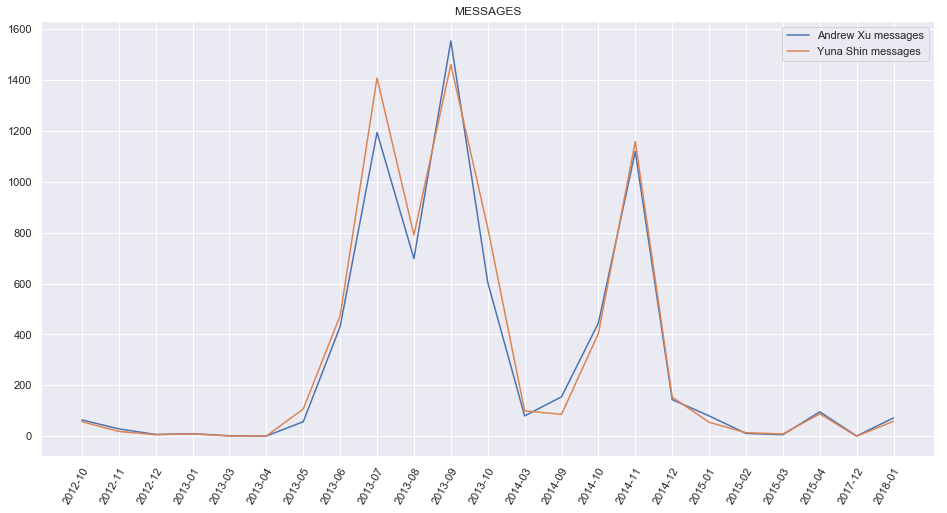

In [23]:
fig, ax = plt.subplots(figsize=(16,8))
ax.plot(df_ind[NAME_MSG], label=NAME_MSG)
ax.plot(df_ind[OTHER_MSG], label=OTHER_MSG)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MESSAGES")
ax.legend()
plt.show()

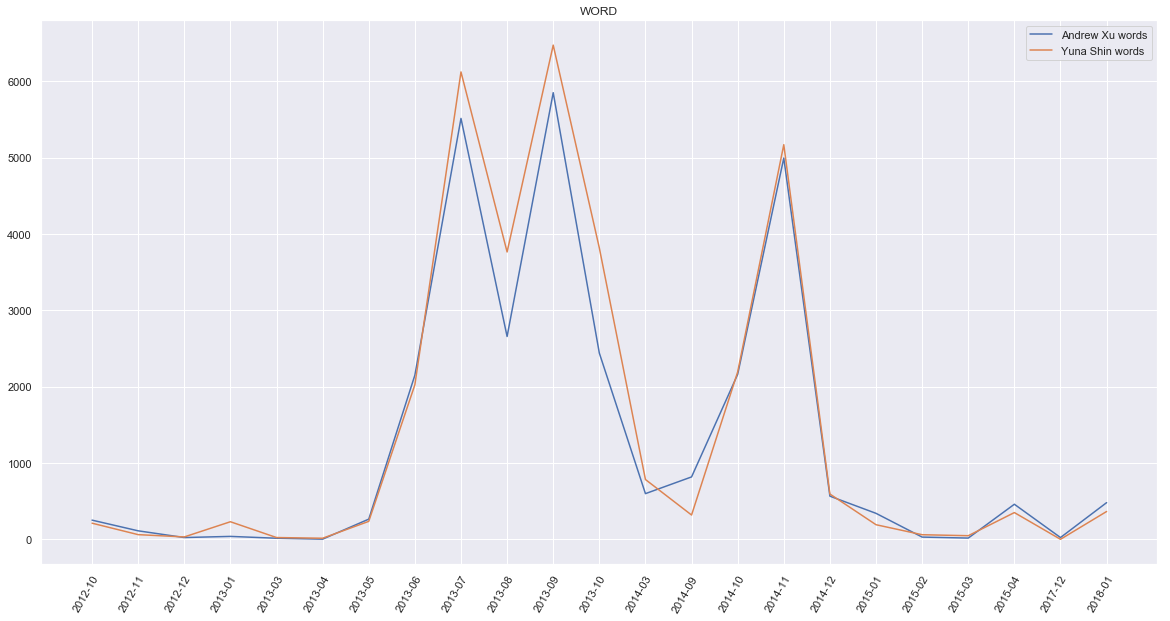

In [24]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_WORD], label=NAME_WORD)
ax.plot(df_ind[OTHER_WORD], label=OTHER_WORD)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("WORD")
ax.legend()
plt.show()

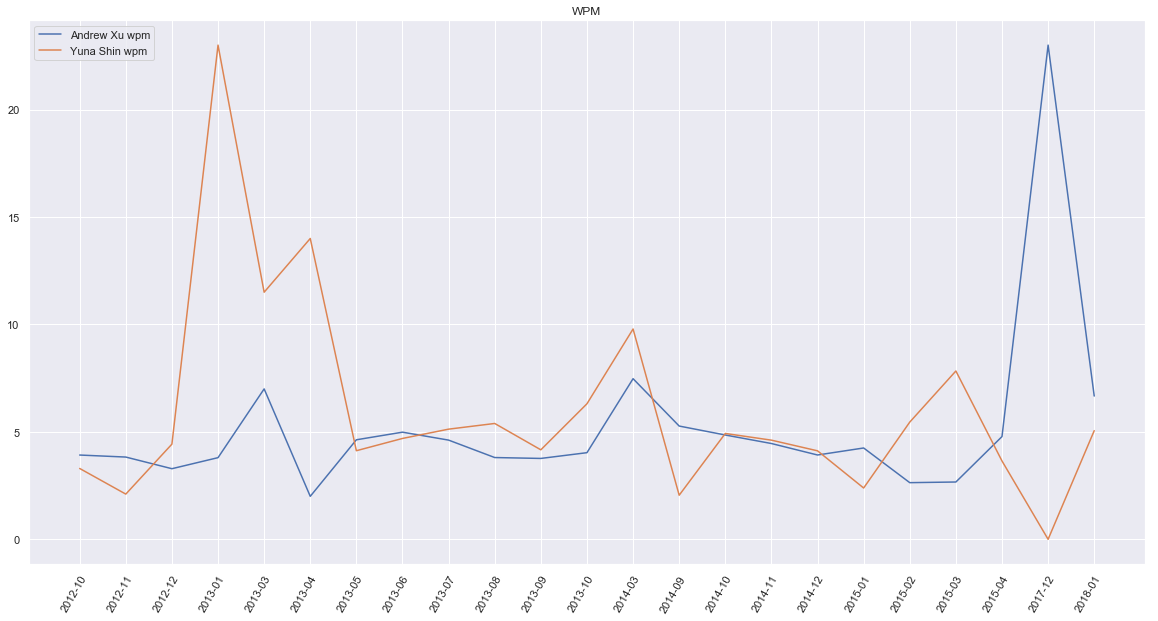

In [25]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_WPM], label=NAME_WPM)
ax.plot(df_ind[OTHER_WPM], label=OTHER_WPM)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("WPM")
ax.legend()

plt.show()

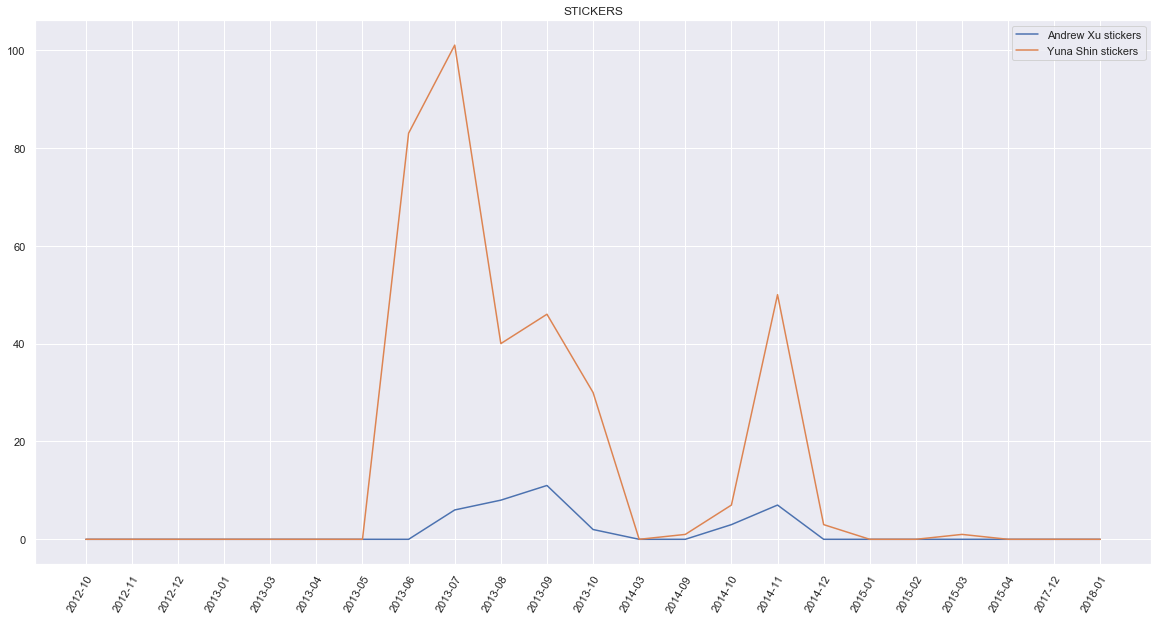

In [26]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_STK], label=NAME_STK)
ax.plot(df_ind[OTHER_STK], label=OTHER_STK)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("STICKERS")
ax.legend()
plt.show()

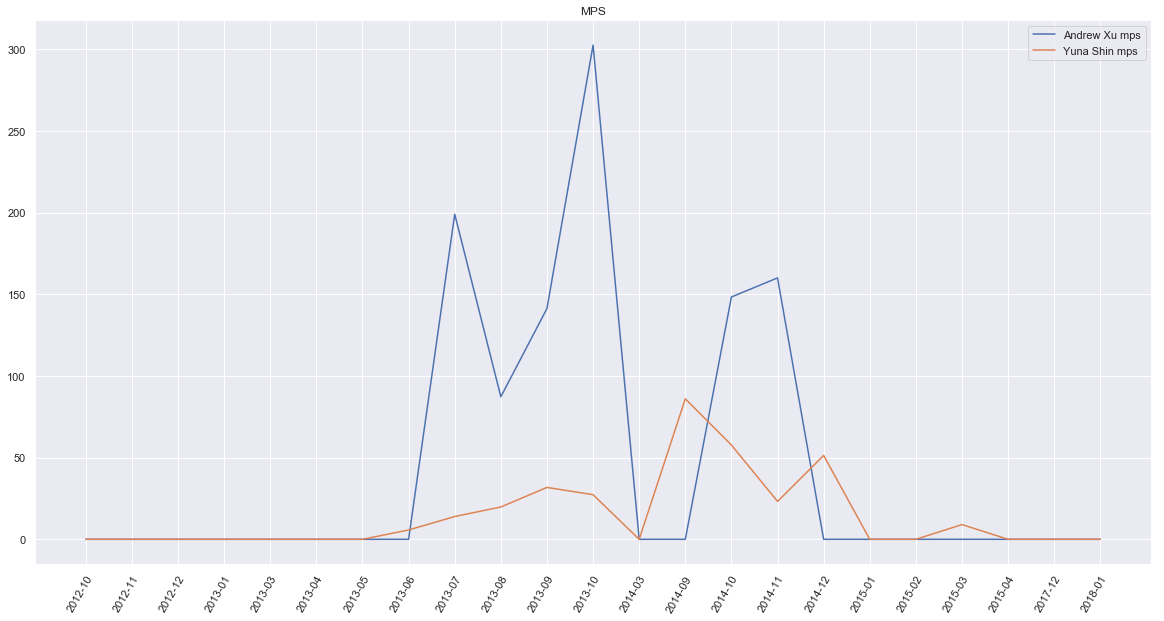

In [27]:
fig, ax = plt.subplots(figsize=(20,10))
ax.plot(df_ind[NAME_MPS], label=NAME_MPS)
ax.plot(df_ind[OTHER_MPS], label=OTHER_MPS)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MPS")
ax.legend()
plt.show()

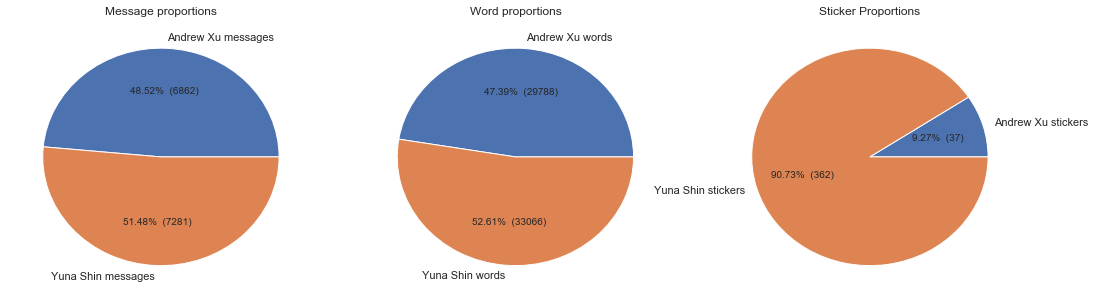

In [28]:
labels = list(df_ind)[:6]

fig, axes = plt.subplots(1,3, figsize=(18,5))

msg_vals = [chat.messages_sent, chat.total_messages - chat.messages_sent]
axes[0].pie(msg_vals, labels=labels[:2], autopct=make_autopct(msg_vals))
axes[0].set_title("Message proportions")

word_vals = [chat.words_sent, chat.total_words - chat.words_sent]
axes[1].pie(word_vals, labels=labels[2:4], autopct=make_autopct(word_vals))
axes[1].set_title("Word proportions")

stk_vals = [chat.stickers_sent, chat.total_stickers - chat.stickers_sent]
axes[2].pie(stk_vals, labels=labels[4:6], autopct=make_autopct(stk_vals))
axes[2].set_title("Sticker Proportions")
plt.show()

In [29]:
pd.set_option('display.max_rows', None)
columns = ""
for i, person in enumerate(chat.participants):
    columns += person + ",freq{},".format(i)
columns = columns[:-1].split(",")
display(pd.DataFrame(table.T, columns=columns))

NameError: name 'display' is not defined

## Groupchats

In [ ]:
groupchats = get_groupchats(chats)

In [ ]:
sorted([(k, v.total_messages) for k, v in groupchats.items() if v.total_messages > 1000], key=lambda x: x[1])

In [ ]:
GROUPCHAT_NAME = "" # Groupchat names which are listed above

In [ ]:
chat = chats[GROUPCHAT_NAME]

## Run through these run at a time please (Interactive graphs)

In [ ]:
df_groupchat_msg = pd.DataFrame(chat.get_data("messages")).transpose().fillna(0)[::-1]
COLOR_DICT = {name: color for name, color in zip(list(df_groupchat_msg), colors)}
area_plot(df_groupchat_msg, "Groupchat messages")
area_plot(conv_to_perc(df_groupchat_msg), "Groupchat msg percentage")
time.sleep(10) # SLEEP TO ALLOW GRAPHS TO LOAD

In [ ]:
df_groupchat_word= pd.DataFrame(chat.get_data("words")).transpose().fillna(0)[::-1]
area_plot(df_groupchat_word, "Groupchat words")
area_plot(conv_to_perc(df_groupchat_word), "Groupchat word percentage")
time.sleep(10)

In [ ]:
df_groupchat_stk = pd.DataFrame(chat.get_data("stickers")).transpose().fillna(0)[::-1]
area_plot(df_groupchat_stk, "Groupchat stickers")
area_plot(conv_to_perc(df_groupchat_stk), "Groupchat sticker percentage")
time.sleep(10)

## Inline graphs

In [ ]:
df_groupchat_msg.sum().sort_values()

In [ ]:
labels = list(df_groupchat_msg.sum().sort_values().keys())
msgs = [x for x in list(df_groupchat_msg.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Messages")
# plt.pie(xd, labels=labels, autopct=make_autopct(xd))
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_groupchat_msg.sum().sort_values().keys(), y=df_groupchat_msg.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("Messages")
plt.show()


In [ ]:
df_groupchat_word.sum().sort_values()

In [ ]:
labels = list(df_groupchat_word.sum().sort_values().keys())
msgs = [x for x in list(df_groupchat_word.sum().sort_values().values)]
plt.figure(figsize=(10,10))
plt.title("Words")
# plt.pie(xd, labels=labels, autopct=make_autopct(xd))
plt.pie(msgs, labels=labels, autopct="%.1f%%")
plt.show()

In [ ]:
plt.figure(figsize=(20,10))
sns.barplot(x=df_groupchat_word.sum().sort_values().keys(), y=df_groupchat_word.sum().sort_values().values)
plt.xticks(rotation=70)
plt.title("words")
plt.show()


In [ ]:
(df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values()

In [ ]:
y_pos = np.arange(len(list(df_groupchat_word)))
plt.figure(figsize=(10,10))
values = (df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values().values
labels = (df_groupchat_word.sum()/df_groupchat_msg.sum()).sort_values().keys()
plt.barh(y_pos, values)
plt.yticks(y_pos, labels)
plt.title("Average WPM")
# plt.set_ytickslabels(labels)
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(16,8))
colors = [c for c, _ in zip(cycle(Category20_20), range(len(df_groupchat_msg)))]
for i, person in enumerate(df_groupchat_msg):
    ax.plot(df_groupchat_msg[person], label=person, color=colors[i])
# ax.plot(df_ind[NAME_MSG], label=NAME_MSG)
# ax.plot(df_ind[OTHER_MSG], label=OTHER_MSG)
plt.setp(ax.get_xticklabels(), rotation=60, ha="right",
         rotation_mode="anchor")
plt.title("MESSAGES")
ax.legend()
plt.show()